# Article Clustering and Quality Scoring

This notebook explores quality scoring based on article clustering using embeddings.
The hypothesis is that news mentioned across multiple sources is likely more important.

## Goals

1. **Load RSS data** - Use our collected RSS feed data
2. **Generate embeddings** - Create semantic embeddings for articles
3. **Cluster similar articles** - Group articles that likely cover the same news story
4. **Count source mentions** - Track how many unique sources cover each story
5. **Quality scoring** - Score articles based on source diversity and importance
6. **Analysis & visualization** - Understand patterns and validate approach

## Expected Outcomes

- Identify major news stories that are covered across multiple sources
- Create a quality scoring system based on source diversity
- Find articles that are likely duplicates or very similar
- Generate insights about news coverage patterns


## Setup and Imports


In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import List, Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Clustering and embeddings
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Progress tracking
from tqdm.auto import tqdm

print("✅ All imports loaded successfully")
print(f"📅 Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


✅ All imports loaded successfully
📅 Analysis date: 2025-09-22 17:21:32


## Load and Prepare Data


In [2]:
# Load RSS data
print("📂 Loading RSS data...")
with open('../data/rss/rss_data.json', 'r', encoding='utf-8') as f:
    rss_data = json.load(f)

articles = rss_data['articles']
metadata = rss_data['metadata']

print(f"✅ Loaded {len(articles)} articles from {metadata['feeds_processed']} feeds")
print(f"📊 Date range: {metadata['collection_date']}")
print(f"📈 Categories: {list(metadata['categories'].keys())}")


📂 Loading RSS data...
✅ Loaded 491 articles from 77 feeds
📊 Date range: 2025-09-22T15:03:54.233787
📈 Categories: ['Tech News', 'Hardware/Gadgets', 'Apple News', 'Big Tech', 'Cybersecurity', 'Data Science', 'AI/ML', 'Developer / Security / Networking', 'Cloud/Enterprise', 'Tech Blog', 'Android News', 'Enterprise Tech', 'Developer']


In [3]:
# Convert to DataFrame for easier manipulation
df = pd.DataFrame(articles)

# Clean and prepare text data
def prepare_article_text(row):
    """Combine title, summary, and content for embedding"""
    title = str(row.get('title', ''))
    summary = str(row.get('summary', ''))
    content = str(row.get('content', ''))[:500]  # Limit content length
    
    # Combine with separators
    combined = f"{title}. {summary}. {content}"
    return combined.strip()

df['combined_text'] = df.apply(prepare_article_text, axis=1)

# Remove articles with very short text
df = df[df['combined_text'].str.len() > 50]

print(f"📝 Prepared {len(df)} articles for clustering")
print(f"📏 Text length stats:")
print(f"   Min: {df['combined_text'].str.len().min()} chars")
print(f"   Max: {df['combined_text'].str.len().max()} chars")
print(f"   Mean: {df['combined_text'].str.len().mean():.0f} chars")


📝 Prepared 483 articles for clustering
📏 Text length stats:
   Min: 51 chars
   Max: 7572 chars
   Mean: 563 chars


## Generate Article Embeddings


In [4]:
# Initialize sentence transformer model
print("🤖 Loading sentence transformer model...")
model = SentenceTransformer('all-MiniLM-L6-v2')  # Fast and effective for clustering

# Generate embeddings
print("🔄 Generating embeddings...")
texts = df['combined_text'].tolist()

# Process in batches to avoid memory issues
batch_size = 50
embeddings = []

for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
    batch = texts[i:i + batch_size]
    batch_embeddings = model.encode(batch, convert_to_tensor=False)
    embeddings.extend(batch_embeddings)

embeddings = np.array(embeddings)
print(f"✅ Generated embeddings: {embeddings.shape}")


🤖 Loading sentence transformer model...
🔄 Generating embeddings...


Generating embeddings:   0%|          | 0/10 [00:00<?, ?it/s]

✅ Generated embeddings: (483, 384)


## Clustering Analysis


In [5]:
# Calculate similarity matrix
print("🔄 Calculating similarity matrix...")
similarity_matrix = cosine_similarity(embeddings)
print(f"✅ Similarity matrix shape: {similarity_matrix.shape}")

# Apply DBSCAN clustering
print("🔍 Applying DBSCAN clustering...")
dbscan = DBSCAN(eps=0.3, min_samples=2, metric='cosine')
clusters = dbscan.fit_predict(embeddings)

# Analyze clustering results
unique_clusters = np.unique(clusters)
n_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
n_noise = list(clusters).count(-1)

print(f"📊 Clustering Results:")
print(f"   Total clusters: {n_clusters}")
print(f"   Noise points (no cluster): {n_noise}")
print(f"   Clustered articles: {len(df) - n_noise}")


🔄 Calculating similarity matrix...
✅ Similarity matrix shape: (483, 483)
🔍 Applying DBSCAN clustering...
📊 Clustering Results:
   Total clusters: 48
   Noise points (no cluster): 339
   Clustered articles: 144


In [9]:
# Add cluster information to dataframe
df['cluster_id'] = clusters
df['is_clustered'] = clusters != -1

# Calculate cluster statistics
cluster_stats = df.groupby('cluster_id').agg({
    'title': 'count',
    'feed_name': lambda x: x.nunique(),
    'feed_category': lambda x: x.nunique()
}).rename(columns={
    'title': 'article_count',
    'feed_name': 'unique_sources',
    'feed_category': 'unique_categories'
})

# Add cluster statistics to each row in the dataframe
df = df.merge(cluster_stats, left_on='cluster_id', right_index=True, how='left')

print("📈 Top clusters by article count:")
print(cluster_stats.sort_values('article_count', ascending=False).head(10))

print("\n📈 Top clusters by source diversity:")
print(cluster_stats.sort_values('unique_sources', ascending=False).head(10))


📈 Top clusters by article count:
            article_count  unique_sources  unique_categories
cluster_id                                                  
-1                    339              50                 13
 3                     12              10                  3
 4                     10               8                  3
 42                     8               2                  2
 16                     7               7                  2
 2                      5               5                  2
 35                     5               4                  4
 15                     4               4                  3
 30                     4               4                  1
 11                     4               4                  1

📈 Top clusters by source diversity:
            article_count  unique_sources  unique_categories
cluster_id                                                  
-1                    339              50                 13
 3             

## Quality Scoring System


In [10]:
def calculate_quality_score(row, cluster_stats):
    """Calculate quality score based on clustering and source diversity"""
    cluster_id = row['cluster_id']
    
    if cluster_id == -1:  # No cluster (unique article)
        return 1.0  # Base score for unique content
    
    # Get cluster statistics
    cluster_data = cluster_stats.loc[cluster_id]
    article_count = cluster_data['article_count']
    unique_sources = cluster_data['unique_sources']
    unique_categories = cluster_data['unique_categories']
    
    # Calculate base score from source diversity
    source_score = min(unique_sources / 5.0, 1.0)  # Normalize to max 5 sources
    
    # Bonus for category diversity
    category_bonus = min(unique_categories / 3.0, 0.3)  # Max 0.3 bonus
    
    # Penalty for too many articles (might be spam/low-quality)
    volume_penalty = max(0, (article_count - 5) * 0.1)  # Penalty after 5 articles
    
    # Combine scores
    quality_score = source_score + category_bonus - volume_penalty
    return max(0.1, min(2.0, quality_score))  # Clamp between 0.1 and 2.0

# Calculate quality scores
df['quality_score'] = df.apply(lambda row: calculate_quality_score(row, cluster_stats), axis=1)

print("📊 Quality Score Statistics:")
print(f"   Min: {df['quality_score'].min():.3f}")
print(f"   Max: {df['quality_score'].max():.3f}")
print(f"   Mean: {df['quality_score'].mean():.3f}")
print(f"   Median: {df['quality_score'].median():.3f}")


📊 Quality Score Statistics:
   Min: 0.400
   Max: 1.300
   Mean: 0.930
   Median: 1.000


## Analysis and Visualization


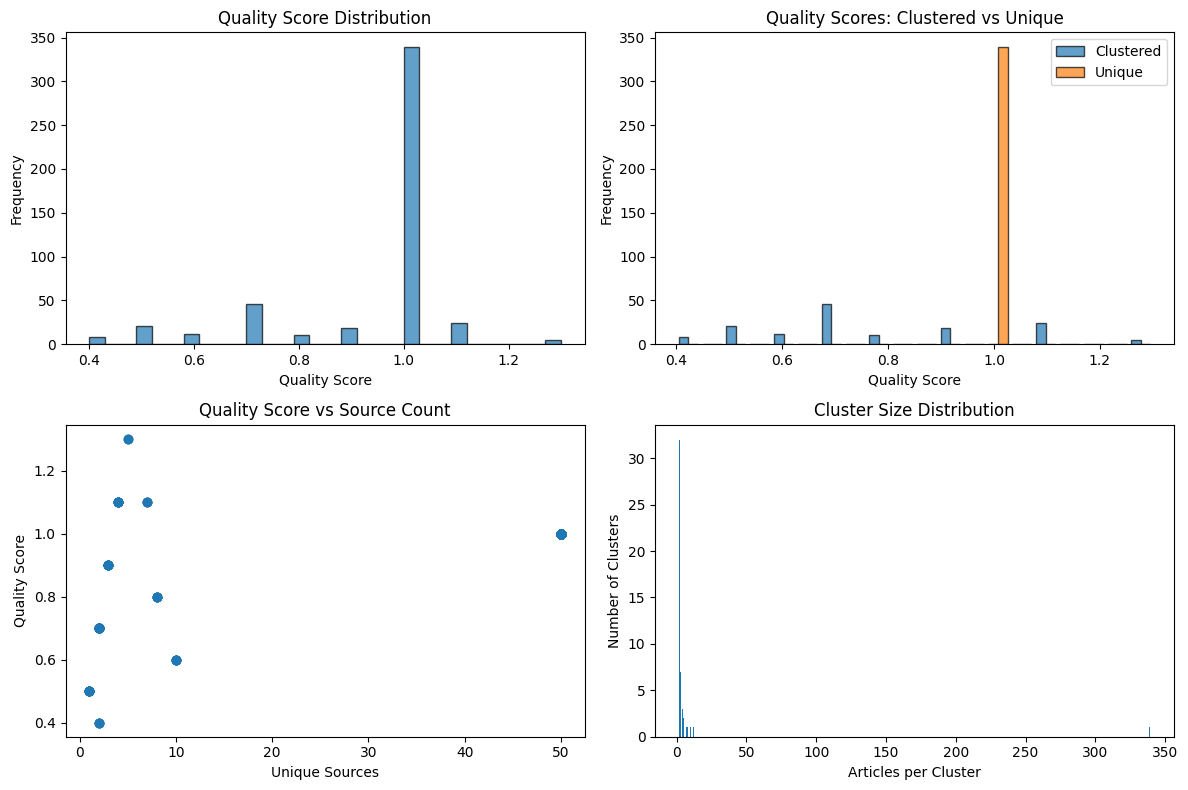

In [11]:
# Visualize quality score distribution
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(df['quality_score'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Quality Score Distribution')
plt.xlabel('Quality Score')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
clustered_scores = df[df['is_clustered']]['quality_score']
unique_scores = df[~df['is_clustered']]['quality_score']
plt.hist([clustered_scores, unique_scores], bins=20, alpha=0.7, 
         label=['Clustered', 'Unique'], edgecolor='black')
plt.title('Quality Scores: Clustered vs Unique')
plt.xlabel('Quality Score')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 3)
plt.scatter(df['unique_sources'], df['quality_score'], alpha=0.6)
plt.title('Quality Score vs Source Count')
plt.xlabel('Unique Sources')
plt.ylabel('Quality Score')

plt.subplot(2, 2, 4)
cluster_size_counts = cluster_stats['article_count'].value_counts().sort_index()
plt.bar(cluster_size_counts.index, cluster_size_counts.values)
plt.title('Cluster Size Distribution')
plt.xlabel('Articles per Cluster')
plt.ylabel('Number of Clusters')

plt.tight_layout()
plt.show()


In [12]:
# Show top quality articles
print("🏆 Top 10 Articles by Quality Score:")
top_articles = df.nlargest(10, 'quality_score')[['title', 'feed_name', 'quality_score', 'cluster_id', 'unique_sources']]

for idx, row in top_articles.iterrows():
    cluster_info = f"Cluster {row['cluster_id']}" if row['cluster_id'] != -1 else "Unique"
    print(f"\n{row['title'][:80]}...")
    print(f"   Source: {row['feed_name']} | Score: {row['quality_score']:.3f} | {cluster_info} | Sources: {row['unique_sources']}")


🏆 Top 10 Articles by Quality Score:

Here’s what’s happening right now with the US TikTok deal...
   Source: TechCrunch | Score: 1.300 | Cluster 2 | Sources: 5

TikTok Deal Moves Forward: New Algorithm or Brand-New App in the US?...
   Source: CNET News | Score: 1.300 | Cluster 2 | Sources: 5

TikTok algorithm to be retrained on US user data under Trump deal...
   Source: BBC News - Technology | Score: 1.300 | Cluster 2 | Sources: 5

How TikTok's deal to stay in the US will work, according to the White House...
   Source: Business Insider (Tech) | Score: 1.300 | Cluster 2 | Sources: 5

TikTok’s algorithm will be retrained in US ‘from the ground up,’ per report...
   Source: 9to5Mac | Score: 1.300 | Cluster 2 | Sources: 5

Our fave Star Wars duo is back in Mandalorian and Grogu teaser...
   Source: Ars Technica | Score: 1.100 | Cluster 11 | Sources: 4

Disney's Mandalorian and Grogu trailer shows the fall of a lumbering giant...
   Source: Engadget | Score: 1.100 | Cluster 11 | Sources:

In [13]:
# Show largest clusters (most covered stories)
print("📰 Largest Clusters (Most Covered Stories):")
largest_clusters = cluster_stats.nlargest(5, 'article_count')

for cluster_id, stats in largest_clusters.iterrows():
    if cluster_id == -1:  # Skip noise cluster
        continue
        
    print(f"\n🔍 Cluster {cluster_id}:")
    print(f"   Articles: {stats['article_count']}")
    print(f"   Unique Sources: {stats['unique_sources']}")
    print(f"   Categories: {stats['unique_categories']}")
    
    # Show sample articles from this cluster
    cluster_articles = df[df['cluster_id'] == cluster_id]
    print(f"   Sample titles:")
    for i, (_, article) in enumerate(cluster_articles.head(3).iterrows()):
        print(f"     {i+1}. {article['title'][:70]}... ({article['feed_name']})")


📰 Largest Clusters (Most Covered Stories):

🔍 Cluster 3:
   Articles: 12
   Unique Sources: 10
   Categories: 3
   Sample titles:
     1. The billion-dollar infrastructure deals powering the AI boom... (TechCrunch)
     2. Nvidia plans to invest up to $100B in OpenAI... (TechCrunch)
     3. Nvidia is partnering up with OpenAI to offer compute and cash... (The Verge)

🔍 Cluster 4:
   Articles: 10
   Unique Sources: 8
   Categories: 3
   Sample titles:
     1. Google’s Gemini AI is coming to your TV... (TechCrunch)
     2. TCL’s Google TVs with an mmWave presence sensor are out now... (The Verge)
     3. Gemini arrives on Google TV... (Engadget)

🔍 Cluster 42:
   Articles: 8
   Unique Sources: 2
   Categories: 2
   Sample titles:
     1. iOS 26.1 beta adds new languages for AirPods Live Translation and Appl... (9to5Mac)
     2. Apple is rolling out visionOS 26.1 developer beta 1... (9to5Mac)
     3. Apple releases macOS Tahoe 26.1 developer beta 1... (9to5Mac)

🔍 Cluster 16:
   Articles:

## Save Results


In [14]:
# Prepare results for saving
results = {
    'metadata': {
        'timestamp': datetime.now().isoformat(),
        'total_articles': len(df),
        'total_clusters': n_clusters,
        'noise_points': n_noise,
        'clustered_articles': len(df) - n_noise,
        'model_used': 'all-MiniLM-L6-v2',
        'clustering_method': 'DBSCAN'
    },
    'cluster_statistics': cluster_stats.to_dict('index'),
    'quality_score_stats': {
        'min': float(df['quality_score'].min()),
        'max': float(df['quality_score'].max()),
        'mean': float(df['quality_score'].mean()),
        'median': float(df['quality_score'].median()),
        'std': float(df['quality_score'].std())
    },
    'top_articles': df.nlargest(20, 'quality_score')[
        ['title', 'url', 'feed_name', 'quality_score', 'cluster_id', 'unique_sources']
    ].to_dict('records'),
    'largest_clusters': largest_clusters.to_dict('index')
}

# Save results
output_file = '../data/clustering/clustering_quality_analysis.json'
import os
os.makedirs(os.path.dirname(output_file), exist_ok=True)

with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2, ensure_ascii=False)

print(f"✅ Results saved to {output_file}")
print(f"📊 Analysis complete!")


✅ Results saved to ../data/clustering/clustering_quality_analysis.json
📊 Analysis complete!


## Summary and Insights

This analysis provides:

1. **Article Clustering**: Groups similar articles covering the same news stories
2. **Quality Scoring**: Scores articles based on source diversity and coverage
3. **Source Analysis**: Identifies which stories are covered by multiple sources
4. **Importance Ranking**: Ranks articles by their likely importance

### Key Metrics to Track:
- Articles with quality scores > 1.5 are likely important stories
- Clusters with 3+ sources indicate major news events
- High category diversity suggests broad interest stories

### Next Steps:
- Integrate this scoring into the main filtering pipeline
- Experiment with different clustering parameters
- Add temporal analysis (how stories evolve over time)
- Combine with existing content quality filters
